Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.3.1


![](https://miro.medium.com/max/3500/1*LOpQX-czpHE-7_O5D2llBw.jpeg)

# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n02107683', 'Bernese_mountain_dog', 0.62732685)
('n02108000', 'EntleBucher', 0.07576548)
('n02107908', 'Appenzeller', 0.048663285)
('n02123045', 'tabby', 0.008674746)
('n02107574', 'Greater_Swiss_Mountain_dog', 0.0060823364)


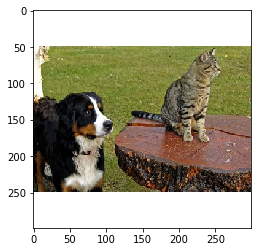

In [4]:
images = transform_img_fn([os.path.join('data','dogs.png')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## Explanation
Now let's get an explanation

In [5]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [6]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [7]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

Wall time: 3min 20s


### Now let's see the explanation for the top class ( Bernese Mountain Dog )

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [8]:
from skimage.segmentation import mark_boundaries

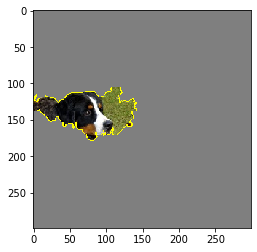

In [9]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

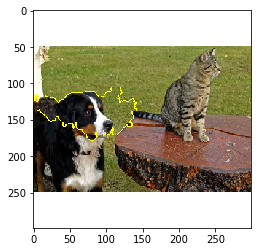

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

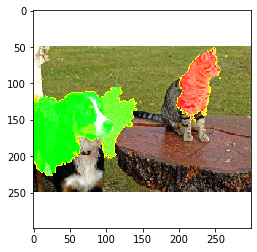

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

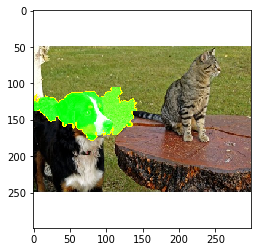

In [12]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for the cat

Most positive towards `tabby`:

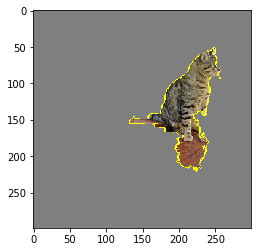

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

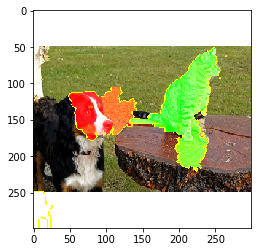

In [21]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
